# Compute Topological Features

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd

1. Calculate Graph Features
- Use networkx or similar tools to calculate features such as
    - Number of nodes/edges
    - Average clustering coefficient
    - Density
    - Diameter

In [2]:
cities = [
    "Bangkok, Thailand",
    "Singapore",
    "Berlin, Germany",
    "New York, USA",
    "London, UK",
    "Tokyo, Japan",
    "Paris, France",
    "Sydney, Australia",
    "Los Angeles, USA",
    "Mumbai, India",
    "Mexico City, Mexico",
    "Dubai, UAE",
    "Moscow, Russia",
    "Istanbul, Turkey",
    "Seoul, South Korea",
    "Beijing, China",
    "Taipei, Taiwan",
    "Osaka, Japan",
    "Atlanta, USA"
]

In [3]:
# Function to extract main roads only
def extract_main_roads(place):
    # Download road network
    G = ox.graph_from_place(place, network_type="drive")
    
    # Retain only main roads (primary, secondary, trunk)
    main_roads = ox.graph_from_place(
        place, network_type="drive", retain_all=False, custom_filter='["highway"~"primary|secondary|trunk"]'
    )
    return main_roads

# Function to compute features
def compute_features(graph, city):
    
    # Focus on the largest connected component
    if nx.is_directed(graph):
        largest_scc = max(nx.strongly_connected_components(graph), key=len)
        graph = graph.subgraph(largest_scc).copy()
    else:
        largest_cc = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_cc).copy()

    # Create simple graph for clustering coefficient
    G_simple = nx.Graph()

    for u, v, data in graph.edges(data=True):
        if G_simple.has_edge(u, v):
            if data.get('length', float('inf')) < G_simple[u][v]['length']:
                G_simple.add_edge(u, v, **data)
        else:
            G_simple.add_edge(u, v, **data)
    
    # Now compute average clustering coefficient
    average_clustering = nx.average_clustering(G_simple)
    
    # Compute features
    features = {
        'city': city,
        'nodes': len(graph.nodes),
        'edges': len(graph.edges),
        'density': nx.density(graph),
        'diameter': max(
            max(nx.shortest_path_length(graph, source=node).values())
            for node in list(graph.nodes)
        ),
        'clustering_coefficient': nx.average_clustering(G_simple)
    }
    return features

In [19]:
features_list = []

for city in cities:
    
    print(city)
    
    main_roads = extract_main_roads(city)

    features_list.append(compute_features(main_roads, city))

Bangkok, Thailand
Singapore
Berlin, Germany
New York, USA
London, UK
Tokyo, Japan
Paris, France
Sydney, Australia
Los Angeles, USA
Mumbai, India
Mexico City, Mexico
Dubai, UAE
Moscow, Russia
Istanbul, Turkey
Seoul, South Korea
Beijing, China
Taipei, Taiwan
Osaka, Japan
Atlanta, USA


In [21]:
feature_df = pd.DataFrame(features_list)

2. Feature Scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler

# Normalize features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(feature_df.drop(columns=["city"]))
normalized_df = pd.DataFrame(normalized_features, columns=feature_df.columns[1:])
normalized_df["city"] = feature_df["city"]

3. Clustering
   - K-Means
   - HDBSCAN

## K-Means Clustering

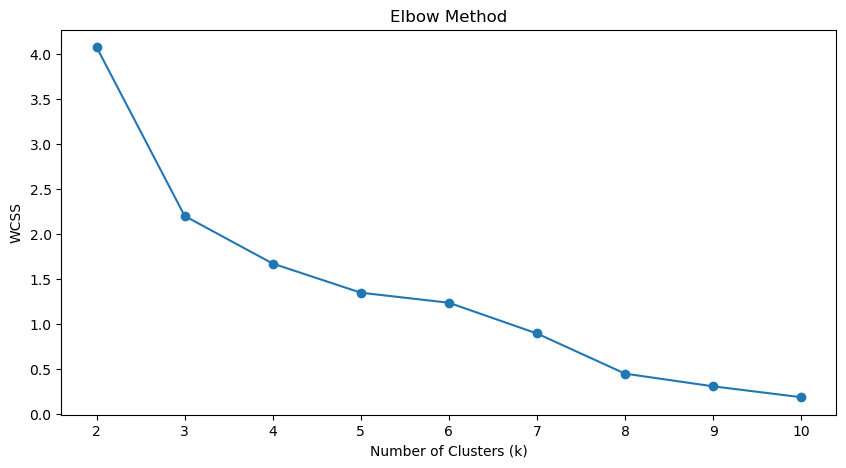

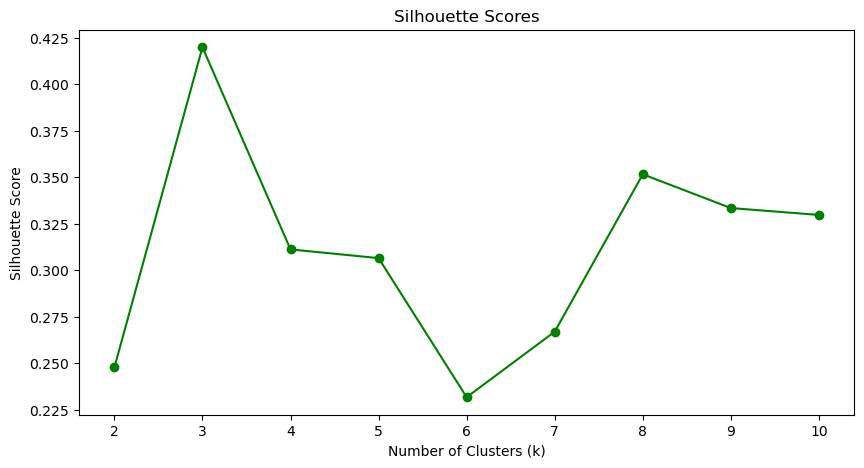

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Example feature matrix (normalized)
X = normalized_features

# Elbow Method
wcss = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [24]:
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
feature_df["cluster"] = kmeans.fit_predict(normalized_features)

print(feature_df[["city", "cluster"]])

                   city  cluster
0     Bangkok, Thailand        2
1             Singapore        2
2       Berlin, Germany        2
3         New York, USA        2
4            London, UK        0
5          Tokyo, Japan        2
6         Paris, France        1
7     Sydney, Australia        0
8      Los Angeles, USA        2
9         Mumbai, India        2
10  Mexico City, Mexico        2
11           Dubai, UAE        2
12       Moscow, Russia        2
13     Istanbul, Turkey        0
14   Seoul, South Korea        2
15       Beijing, China        2
16       Taipei, Taiwan        1
17         Osaka, Japan        1
18         Atlanta, USA        1


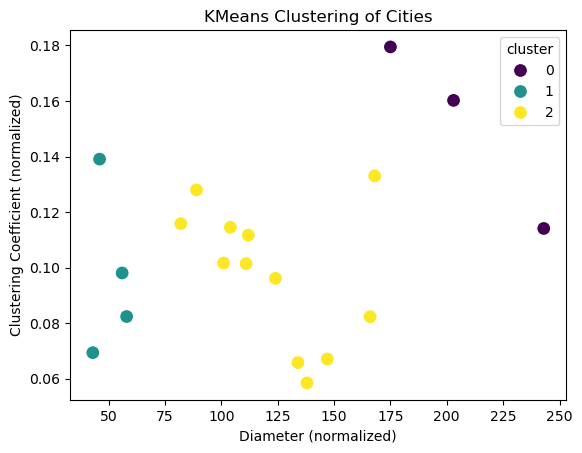

In [25]:
import seaborn as sns

sns.scatterplot(
    x=feature_df["diameter"],
    y=feature_df["clustering_coefficient"],
    hue=feature_df["cluster"],
    palette="viridis", s=100
)
plt.title("KMeans Clustering of Cities")
plt.xlabel("Diameter (normalized)")
plt.ylabel("Clustering Coefficient (normalized)")
plt.show()

## HDBSCAN

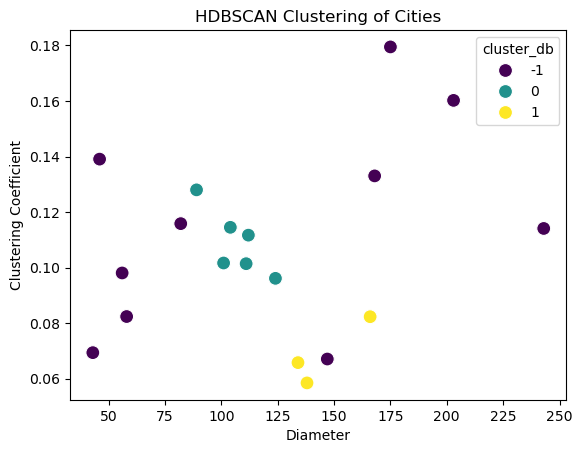

Clustering Results:
                   city  cluster  cluster_db
0     Bangkok, Thailand        2           1
1             Singapore        2          -1
2       Berlin, Germany        2           0
3         New York, USA        2           0
4            London, UK        0          -1
5          Tokyo, Japan        2           0
6         Paris, France        1          -1
7     Sydney, Australia        0          -1
8      Los Angeles, USA        2           0
9         Mumbai, India        2           0
10  Mexico City, Mexico        2           1
11           Dubai, UAE        2           1
12       Moscow, Russia        2           0
13     Istanbul, Turkey        0          -1
14   Seoul, South Korea        2          -1
15       Beijing, China        2          -1
16       Taipei, Taiwan        1          -1
17         Osaka, Japan        1          -1
18         Atlanta, USA        1          -1


In [26]:
import hdbscan

hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
labels = hdbscan_clusterer.fit_predict(normalized_features)

feature_df['cluster_db'] = labels

sns.scatterplot(
    x=feature_df['diameter'], y=feature_df['clustering_coefficient'],
    hue=feature_df['cluster_db'], palette='viridis', s=100
)
plt.title("HDBSCAN Clustering of Cities")
plt.xlabel("Diameter")
plt.ylabel("Clustering Coefficient")
plt.show()

print("Clustering Results:")
print(feature_df[['city', 'cluster', 'cluster_db']])